In [1]:
import pandas as pd
import numpy as np
import os
import random

#DeepLearning
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import models,layers
#from tensorflow.keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten, Activation, Dropout, Flatten, Dense
# image/data augmentation
import PIL
import PIL.Image

#Visualization
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.4)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))   

#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth=True
#sess = tf.compat.v1.Session(config=config)

Random example train data set:
butterfly : 2112
cat : 1668
chicken : 3098
cow : 1866
dog : 4863
elephant : 1446
horse : 2623
sheep : 1820
spider : 4821
squirrel : 1862
total data:  26179
number of classes in data:  10


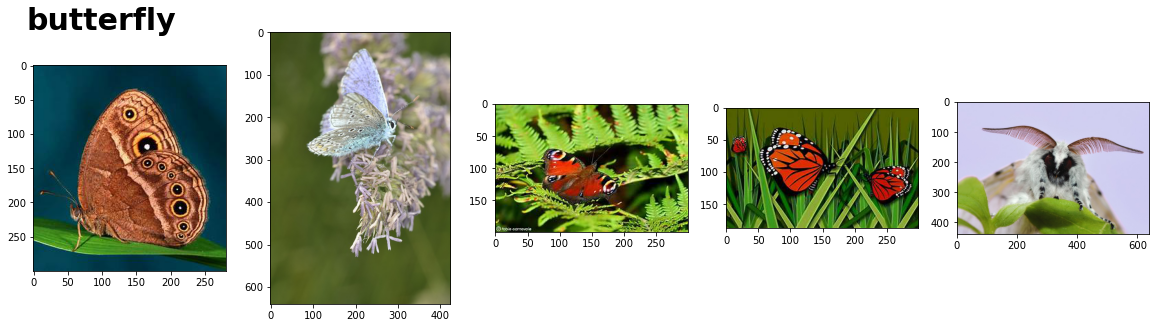

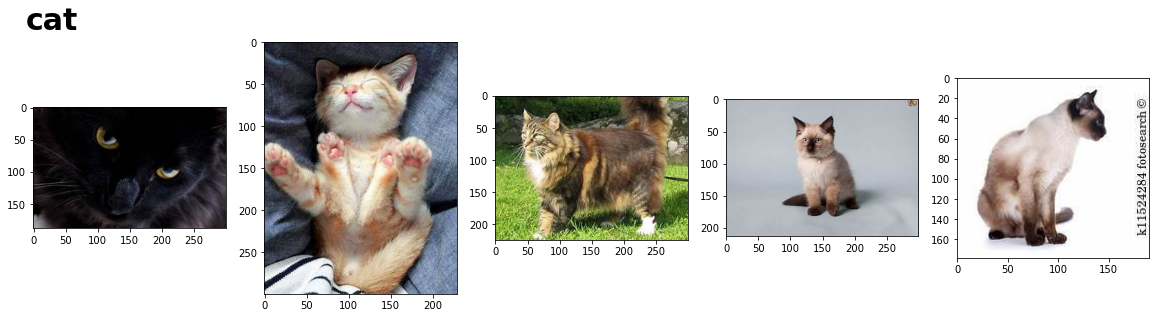

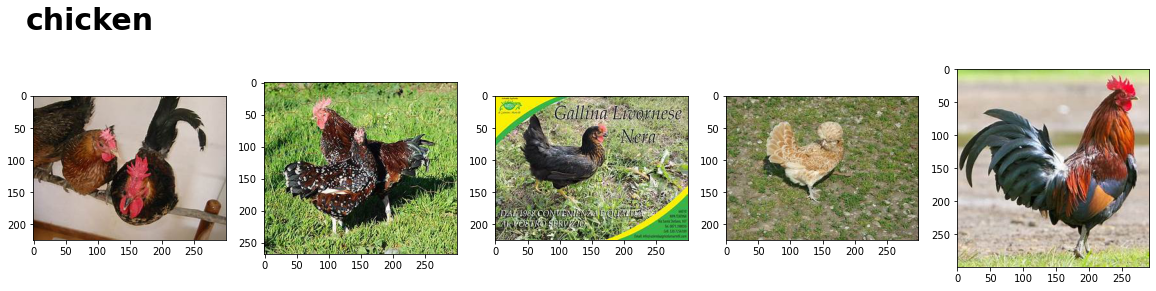

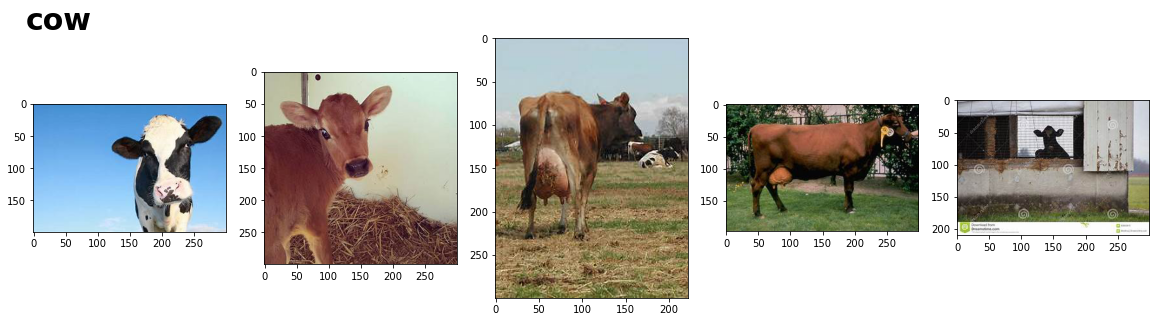

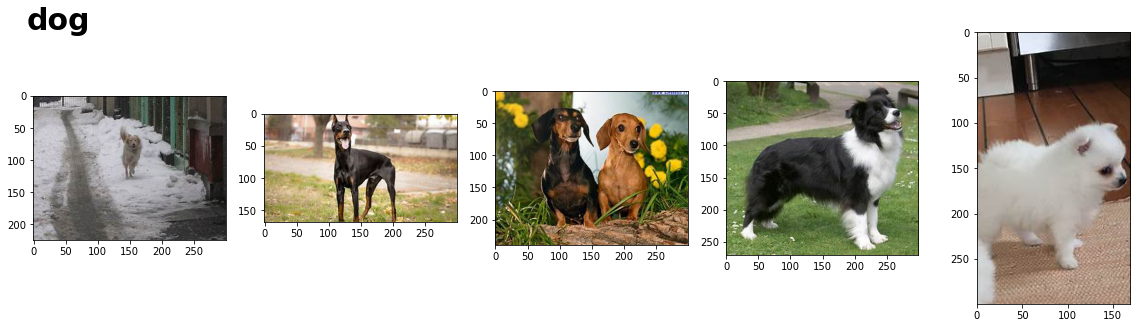

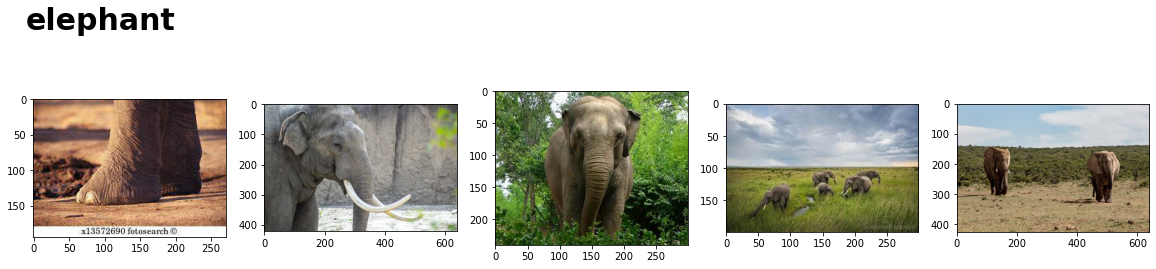

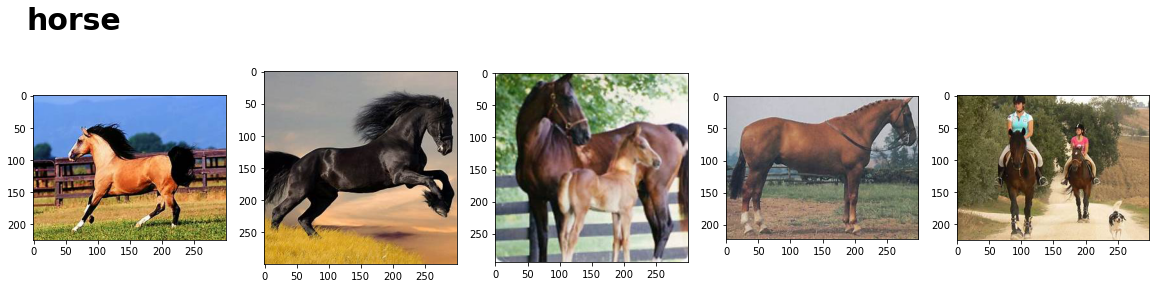

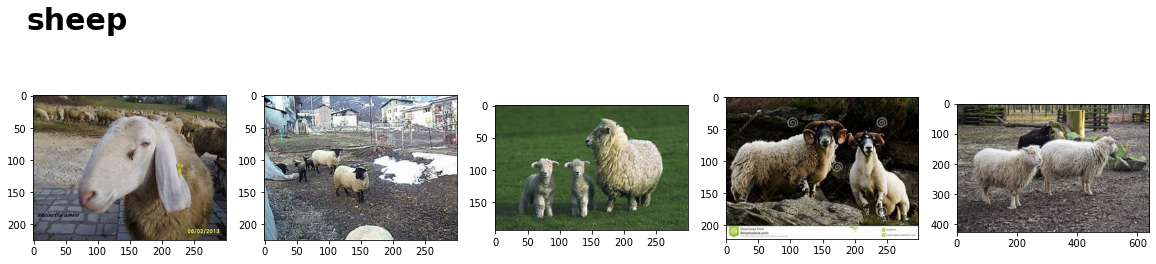

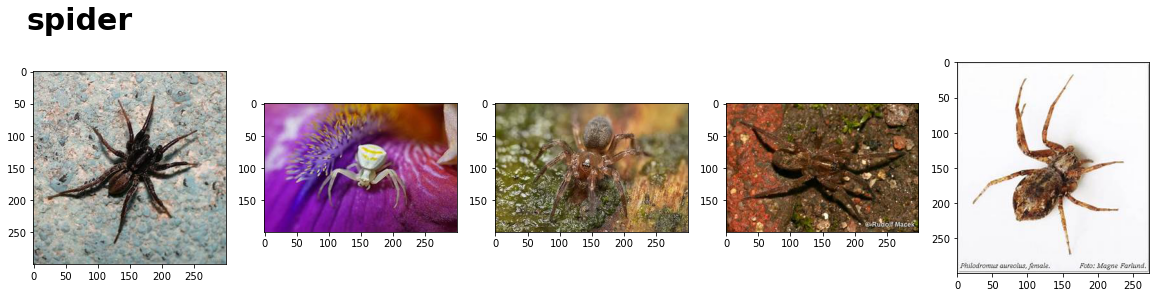

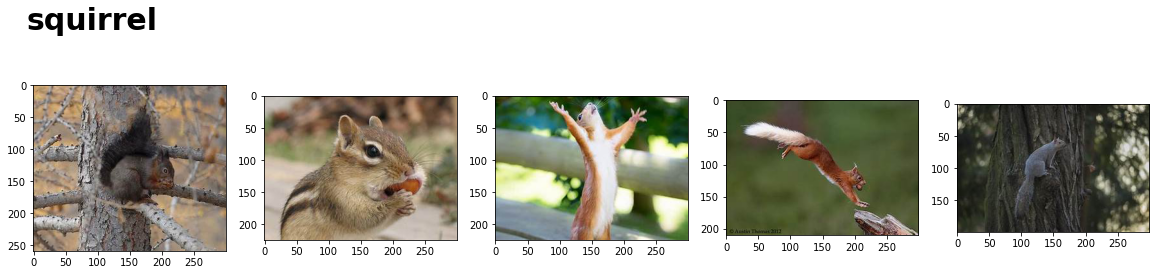

In [3]:
def instant_show(path,title):
    """show sample random sample image"""
    plt.figure(figsize=(20,5))
    plt.suptitle(title,size=30,fontweight="bold",x=0.12, y=.95,ha='left')
    for i in range(5):
        file = random.choice(os.listdir(path))
        image_path= os.path.join(path, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(1,5,i+1)
        #ax.title.set_text(file)
        plt.tight_layout
        plt.imshow(img)

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken",
 "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "cavallo": "horse","ragno": "spider"}
data_directory=r'raw-img'
count_data= 0
print("Random example train data set:")

#translate dataset
for foldername in os.listdir(data_directory):
    try:
        file_path = os.path.join(os.getcwd(),data_directory,foldername)
        new_name=os.path.join(os.getcwd(),data_directory,translate[foldername])
        os.rename(file_path,new_name)
    except:
        pass
#show random data each class
for foldername in os.listdir(data_directory):
    file_path = os.path.join(data_directory,foldername)
    print(foldername,':',len(os.listdir(file_path)))
    instant_show(file_path,foldername)
    count_data+=len(os.listdir(file_path))

print('total data: ', count_data)
print('number of classes in data: ', len(os.listdir(data_directory)))

# Data Preprocessing

## Data Augmentation

In [4]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    validation_split=0.2,
                                  )
val_datagen = ImageDataGenerator( rescale=1./255.,
                                  validation_split=0.2
                                )

## Split Data set

In [5]:

#training generator
train_generator= train_datagen.flow_from_directory(batch_size=10,
                                                    directory=data_directory,
                                                    shuffle=True,
                                                    target_size=(224, 224), 
                                                    subset="training",
                                                    class_mode='categorical'
                                                    )
#validation generator
val_generator= val_datagen.flow_from_directory(batch_size=10,
                                                    directory=data_directory,
                                                    shuffle=False,
                                                    target_size=(224, 224), 
                                                    subset="validation",
                                                    class_mode='categorical',
                                                    )

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


# Modeling

## Model1

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
    include_top = False, # Leave out the last fully connected layer
    weights = 'imagenet')

#freeze layer
base_model.trainable= False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(10, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 50)                1254450   
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 15,970,368
Trainable params: 1,255,680
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 50)                1254450   
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 15,970,368
Trainable params: 1,255,680
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
model_name = "model_v1.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [10]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=val_generator,verbose=1,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/15
2019/2095 [===========================>..] - ETA: 16s - loss: 1.4847 - accuracy: 0.4756

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
log_model=pd.DataFrame(history.history)
log_model

### second train

In [ ]:
model=new_model = tf.keras.models.load_model('model_v1.h5')

In [ ]:
model_name = "model_v2.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=val_generator,verbose=1,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

In [ ]:
# Unfreeze layers
for layer in model.layers[0].layers[-5:]:
    layer.trainable = True
for i, layer in enumerate(model.layers[0].layers):
    print(i, layer.name, layer.trainable)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=val_generator,verbose=1,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

In [ ]:
log_model2=pd.DataFrame(history.history)

plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### third training

In [ ]:
new_model = tf.keras.models.load_model('v2_model.h5')

In [ ]:
# Unfreeze all layers
for layer in model.layers[0].layers[:]:
    layer.trainable = True
for layer in model.layers[:]:
    layer.trainable = True
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

In [ ]:
new_model.summary()

In [ ]:
#chekpoint
model_name = "new.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
#early stopping
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)
#learning_rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)
#compile                                           
new_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
history = new_model.fit(train_generator,
                    epochs=15,
                    validation_data=val_generator,verbose=1,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

In [ ]:
log_model3=pd.DataFrame(history.history)

plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
log_model_mix=pd.concat([log_model,log_model2,log_model3], keys=['h1', 'h2','h3'])

plt.figure(figsize=(20,8))
plt.plot(log_model_mix['loss'])
plt.plot(log_model_mix['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
new_model = tf.keras.models.load_model('final.h5')

In [ ]:
export_dir = 'saved_model/'
tf.saved_model.save(new_model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
     
with tf.io.gfile.GFile('animals.tflite', 'wb') as f:
    f.write(tflite_model)